In [1]:
from twittercrawler.utils import tweet_time_2_epoch
from datetime import datetime as dt
import numpy as np
import os

In [2]:
class TweetQuery():
    def __init__(self, tweet_dict):
        self._id = tweet_dict.get("id_str", None)
        self._user_name = tweet_dict["user"]["screen_name"] if "user" in tweet_dict else None
        self._user_id = tweet_dict["user"]["id_str"] if "user" in tweet_dict else None
        self._epoch = tweet_time_2_epoch(tweet_dict["created_at"]) if "created_at" in tweet_dict else None
        self._likes = tweet_dict.get("favorite_count", None)
        self._retweets = tweet_dict.get("retweet_count", None)
        self._max_id = None
        self._since_id = int(self._id) if self._id != None else None
        self._last_access = None
        
    def set_epoch(self, epoch):
        self._epoch = epoch
        
    def set_max_id(self, max_id):
        self._max_id = max_id
        
    def set_since_id(self, since_id):
        self._since_id = int(since_id)
        
    def mark_access(self):
        self._last_access = dt.now()
        
    def copy(self):
        params = {
            "id_str":self.id,
            "favorite_count":self.likes,
            "retweet_count":self.retweets,
            "user":{
                "id_str": self.user_id,
                "screen_name": self.user_name
            }
        }
        copy_q = TweetQuery(params)
        copy_q.set_epoch(self.epoch)
        copy_q.set_max_id(self.max_id)
        copy_q.set_since_id(self.since_id)
        return copy_q
        
    def __repr__(self):
        return "(%s, %s, %s, %s, %i, %i, %s, %s)" % (self.id, self.user_id, self.user_name, self.dt, self.likes, self.retweets, self.max_id, self.since_id)
    
    @property
    def id(self):
        return self._id
    
    @property
    def user_name(self):
        return self._user_name
    
    @property
    def user_id(self):
        return self._user_id
    
    @property
    def epoch(self):
        return self._epoch
    
    @property
    def dt(self):
        return dt.fromtimestamp(self.epoch)
    
    @property
    def likes(self):
        return self._likes
    
    @property
    def retweets(self):
        return self._retweets
    
    @property
    def max_id(self):
        return self._max_id
    
    @property
    def since_id(self):
        return self._since_id
    
    @property
    def elapsed_days(self):
        return (dt.now() - self.dt).days
    
    @property
    def accessed_since_days(self):
        if self._last_access == None:
            return -1
        else:
            return (dt.now() - self._last_access).days
        
    @property
    def priority(self):
        if self.accessed_since_days == 0:
            return 0.0
        else:
            return self.elapsed_days + np.log10(1.0+self.likes+self.retweets)

In [3]:
class UserTweetStore():
    def __init__(self):#dir_path):
        #self._dir_path = dir_path
        self.user_intervals = {}
        
    #@property
    #def dir_path(self):
    #    if not os.path.exists(self._dir_path):
    #        os.makedirs(self._dir_path)
    #    return self._dir_path
    
    def get_user(self, user_id):
        return self.user_intervals.get(user_id, [None, None])
    
    def update(self, query, latest_id):
        user_id = query.user_id
        from_id, to_id = self.get_user(user_id)
        if from_id == None:
            from_id = int(query.id)
        if to_id == None:
            to_id = latest_id
        elif latest_id > to_id:
            to_id = latest_id
        self.user_intervals[user_id] = [from_id, to_id]
    
    def adjust_query(self, query):
        from_id, to_id = self.get_user(query.user_id)
        if from_id != None:
            if query.since_id < from_id:
                raise RuntimeError("Queried tweet (%s, since_id: %i) preceeds oldest tweet (%i) for user_id %s)" % (query.id, query.since_id, from_id, query.user_id))
            else:
                # avoid collecting the same data twice
                query.set_since_id(to_id)
        return query

from twittercrawler.crawlers import RecursiveCrawler
from twittercrawler.utils import load_json_result
    
class SearchEngine():
    def __init__(self, reset=False, api_key_fp="../api_key.json", output_fp="sample.txt", tweet_mode="extended"):
        self.reset = reset
        self.tweet_mode = tweet_mode
        self.output_fp = output_fp
        self.api_key_fp = api_key_fp
        self.store = UserTweetStore()
        self._init_crawler()
        
    def _init_crawler(self):
        if self.reset and os.path.exists(self.output_fp):
            os.remove(self.output_fp)
            print("Engine output file was cleared!")
        self.crawler = RecursiveCrawler()
        self.crawler.authenticate(self.api_key_fp)
        
    def get_status(self, tweet_id):
        return self.crawler.twitter_api.show_status(id=tweet_id, tweet_mode=self.tweet_mode)
        
    def collect_replies(self, query, count=100, result_type='recent'):
        search_params = {
            "q" : "to:%s" % query.user_name,
            "result_type" : result_type,
            "count" : count,
            "tweet_mode" : self.tweet_mode
        }
        #print(search_params, query.since_id)
        self.crawler.connect_to_file(self.output_fp)# TODO: later rewise whteher to use multiple files for users
        self.crawler.set_search_arguments(search_args=search_params)
        if query.max_id != None:
            result = self.crawler.search(wait_for=3, feedback_time=15, current_max_id=query.max_id, custom_since_id=query.since_id)
        else:
            result = self.crawler.search(wait_for=3, feedback_time=15, custom_since_id=query.since_id)
        self.crawler.close()
        return result
    
    def extract_replies(self, query):
        reply_tweets = load_json_result(self.output_fp)
        #print("Hits:", len(reply_tweets))
        replies = []
        for tweet in reply_tweets:
            replied_tweet = tweet.get("in_reply_to_status_id_str", None)
            if replied_tweet == query.id and tweet["id"]:# > query.since_id:
                replies.append(tweet)
        return replies
        
    def execute(self, original_query):
        query = self.store.adjust_query(original_query)
        success, max_id, latest_id, cnt = self.collect_replies(query)
        print(success, max_id, latest_id, cnt)
        replies = self.extract_replies(query)
        if success:
            #print("\nQuery was completed: %s" % query)
            query.mark_access()
            if cnt > 0:
                self.store.update(query, latest_id)
                query.set_since_id(latest_id)
                query.set_max_id(None)
            #    print("New query: %s\n" % query)
            #else:
            #    print("Old query is kept!\n")
        else:
            #print("\nQuery was interrupted: %s" % query)
            query.set_max_id(max_id)
            #print("New query: %s\n" % query)
        return success, query, replies
        
from collections import deque

class ReplyCollector():
    def __init__(self, tweet_id, retweet_limit=0, postpone_day_limit=3, action_day_limit=5, reset=False):
        self.retweet_limit = retweet_limit
        self.postpone_day_limit = postpone_day_limit
        self.action_day_limit = action_day_limit
        self.engine = SearchEngine(output_fp="%s.txt" % tweet_id, reset=reset)
        self.seed_tweet = self.engine.get_status(tweet_id)
        self.tweet_thread = [self.seed_tweet]
        print(self.seed_tweet['full_text'])
        self._queue = deque([TweetQuery(self.seed_tweet)])
        self.active_tweet_ids = []
        
    @property
    def queue(self):
        return self._queue
    
    def _sort_queries(self):
        self._queue = deque(sorted(self._queue, key=lambda x: x.priority, reverse=True))
        
    #def sort_queries(self, queries):
    #    return sorted(queries, key=lambda x: x.since_id)
        
    def _decide_execution(self, query):
        if query.elapsed_days < self.postpone_day_limit:
            execute_now = False
        elif query.elapsed_days >= self.action_day_limit:
            # here we try to catch the begining of each thread
            execute_now = True
        else:
            if query.retweets >= self.retweet_limit:
                execute_now = True
            else:
                execute_now = False
        return execute_now
        
    def run(self):
        while len(self.queue) > 0:
            query = self.queue.popleft()
            print(query)
            if query.priority == 0:
                self._queue.appendleft(query)
                break
            execute_now = self._decide_execution(query)
            if execute_now:
                success, new_query, replies = self.engine.execute(query)
                print(query.id,len(replies))
                self.tweet_thread += replies
                for reply in replies:
                    q = TweetQuery(reply)
                    if not q.id in self.active_tweet_ids:
                        self._queue.append(q)
                self._queue.append(new_query)
                self._sort_queries()
                if not success:
                    break
                #print([q.priority for q in self.queue])
            else:
                self._queue.append(query)
        # TODO: records are never deleted from the queue!!!

In [4]:
#https://twitter.com/hadleywickham/status/1347260334227259394
collector = ReplyCollector("1347260116932976643", retweet_limit=0, postpone_day_limit=0, action_day_limit=0, reset=True)

Engine output file was cleared!
Authentication was successful!
I'm starting to prepare for the release of rvest 1.0.0. It includes big improvements to text and table extraction, and a bunch of minor API improvements. If you're an rvest user, please try out the dev version and let me know how it goes: https://t.co/qgrtknYsIK #rstats


#https://twitter.com/nicvadivelu/status/1347267259266318336/photo/1
collector = ReplyCollector("1347267259266318336", retweet_limit=0, postpone_day_limit=0, action_day_limit=0)

#https://twitter.com/Dr2NisreenAlwan/status/1347833203080523776
collector = ReplyCollector("1347833203080523776", retweet_limit=0, postpone_day_limit=0, action_day_limit=0, reset=True)

In [5]:
collector.run()

(1347260116932976643, 69133574, hadleywickham, 2021-01-07 19:13:37, 498, 70, None, 1347260116932976643)
{'q': 'to:hadleywickham', 'result_type': 'recent', 'count': 100, 'tweet_mode': 'extended'}
Connection was closed successfully!
True 1347260334227259394 1347958944011071489 13
1347260116932976643 5
(1347260334227259394, 69133574, hadleywickham, 2021-01-07 19:14:29, 237, 23, None, 1347260334227259394)
{'q': 'to:hadleywickham', 'result_type': 'recent', 'count': 100, 'tweet_mode': 'extended'}
Connection was closed successfully!
True 0 -1 0
1347260334227259394 2
(1347262328073498626, 5685812, hrbrmstr, 2021-01-07 19:22:24, 4, 0, None, 1347262328073498626)
{'q': 'to:hrbrmstr', 'result_type': 'recent', 'count': 100, 'tweet_mode': 'extended'}
Connection was closed successfully!
True 1347294100987539456 1347579078421880833 33
1347262328073498626 0
(1347261394396319747, 51333376, CICG, 2021-01-07 19:18:41, 1, 0, None, 1347261394396319747)
{'q': 'to:CICG', 'result_type': 'recent', 'count': 100,

#### Due to priority ordering!!! 

In [6]:
thread_events = sorted(collector.tweet_thread, key=lambda x: x["id"])
repliers = set()
edges = []
mentions = []
for tw in thread_events:
    if tw["in_reply_to_status_id_str"] != None:
        edges.append((tw["id_str"],tw["in_reply_to_status_id_str"]))
        mentions.append((tw["user"]["id_str"],tw["in_reply_to_user_id_str"]))
    #repliers.add(tw["user"]["screen_name"])
    #print(tw["user"]["screen_name"], tw["created_at"])
    #print(tw["full_text"])
    #print()

In [7]:
len(edges)

9

In [8]:
len(collector.queue)

10

In [9]:
import networkx as nx
G = nx.DiGraph()
H = nx.MultiDiGraph()
G.add_edges_from(edges)
_ = H.add_edges_from(mentions)

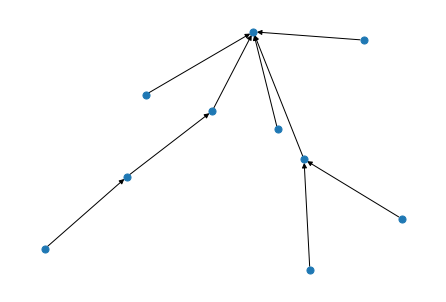

In [10]:
nx.draw(G, node_size=50)

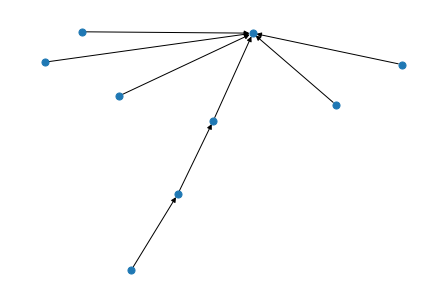

In [11]:
nx.draw(H, node_size=50)